# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import json
import sys, importlib
import os, re
import torch
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def _add_notebooks_src_to_path():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        candidate = p / "notebooks" / "src"
        if candidate.is_dir():
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    raise FileNotFoundError("Could not find 'notebooks/src' from current working directory.")

print("Using helpers from:", _add_notebooks_src_to_path())

from constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint,
    load_notebook_config,
)
ensure_repo_importable()
from device import pick_device
NOTEBOOK_CFG = load_notebook_config()
SEED = int(NOTEBOOK_CFG.get("seed", 42))
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto"))
print(f"Notebook config: seed={SEED}, device={DEVICE}")

if "DEVICE" not in globals():
    import torch
    try:
        from device import pick_device
        DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto") if "NOTEBOOK_CFG" in globals() else "auto")
    except Exception:
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", DEVICE)
for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

# 2) If your notebook already imported `utils`, remove it to avoid collision
if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

# 4) (Optional) sanity check that TGN's local packages resolve
import importlib.util as iu
print("utils.utils   ->", iu.find_spec("utils.utils"))
print("modules.memory->", iu.find_spec("modules.memory"))


print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)


Using helpers from: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/notebooks/src
Notebook config: seed=42, device=mps
utils.utils   -> None
modules.memory-> ModuleSpec(name='modules.memory', loader=<_frozen_importlib_external.SourceFileLoader object at 0x1295372d0>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/models/tgn/modules/memory.py')
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/datasets/processed
MODELS_ROOT      : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models


## Imports

In [2]:
from time_to_explain.utils.graph import NeighborFinder
# Core imports
from time_to_explain.data import load_explain_idx
from time_to_explain.data import load_processed_dataset
from submodules.models.tgat.module import TGAN
from submodules.models.tgn.model.tgn import TGN
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.models.ext.tgn.utils.data_processing import compute_time_statistics

from time_to_explain.core.runner import EvaluationRunner, EvalConfig
import json
METRICS_CFG = json.loads((REPO_ROOT / "configs" / "metrics" / "default.json").read_text())

from time_to_explain.adapters import *
from time_to_explain.extractors.base_extractor import BaseExtractor
from time_to_explain.extractors.khop_extractor import KHopCandidatesExtractor
from time_to_explain.visualization import (
    filter_explainers,
    plot_explainer_metric_summary,
    plot_explainer_runtime,
    prepare_metrics_plotting,
    plot_prediction_match_rate,
)

from time_to_explain.visualization import plot_selected_metrics
from time_to_explain.explainer.shap import ShapAdapterConfig, ShapExplainer
from time_to_explain.explainer.gradient import GradientAdapterConfig, GradientExplainer
from time_to_explain.explainer.tempme import TempMEAdapter, TempMEAdapterConfig
from time_to_explain.explainer.tempme_tgn_impl import TempMETGNImplAdapter, TempMETGNImplAdapterConfig
from time_to_explain.explainer.cody_tgn_impl import CoDyTGNImplAdapter, CoDyTGNImplAdapterConfig





Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain


## Config

In [ ]:
MODEL_TYPE = "tgn"
DATASET_NAME = "wikipedia"
TIME_LIMIT = 240

N = 3
REUSE_EXISTING_RESULTS = False  # True skips recompute when outputs exist
ONLY_CODY = True


## Load Dataset and Model

In [4]:
def _find_checkpoint(models_root: Path, dataset_name: str, model_name: str) -> Path:
    model_name = model_name.lower()
    dataset_name = str(dataset_name)
    candidates = [
        models_root / dataset_name / model_name / f"{model_name}_{dataset_name}_best.pth",
        models_root / dataset_name / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
        models_root / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    search_roots = [
        models_root / dataset_name / model_name,
        models_root / dataset_name,
        models_root / "checkpoints",
        models_root / "runs",
    ]
    for root in search_roots:
        if not root.exists():
            continue
        matches = sorted(root.rglob(f"{model_name}*{dataset_name}*.pth"))
        if not matches:
            matches = sorted(root.rglob("*.pth"))
        for match in matches:
            if "best" in match.name:
                return match
        if matches:
            return matches[0]
    raise FileNotFoundError(
        f"Checkpoint not found under {models_root} for {model_name}_{dataset_name}."
    )

ckpt_path = _find_checkpoint(MODELS_ROOT, DATASET_NAME, MODEL_TYPE)
print("Using checkpoint:", ckpt_path)
explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{DATASET_NAME}.csv")
print("Explain index CSV:", explain_idx_csv)

Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/tgn/tgn_wikipedia_best.pth
Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/wikipedia.csv


In [5]:
# Refine AUFSC sparsity levels (denser between 0.00 and 0.05)
import numpy as np
low_levels = [round(float(x), 4) for x in np.linspace(0.0, 0.05, 11)]
rest_levels = [round(float(x), 4) for x in np.arange(0.06, 0.3001, 0.02)]
aufsc_levels = sorted(set(low_levels + rest_levels))
METRICS_CFG['aufsc']['sparsity_levels'] = aufsc_levels


In [6]:
# Load data
try:
    bundle = load_processed_dataset(DATASET_NAME)
except FileNotFoundError as exc:
    raise FileNotFoundError(
        f"Processed dataset {DATASET_NAME!r} not found. "
        "Run notebooks/00_prepare_datasets.ipynb for this dataset."
    ) from exc
events = bundle["interactions"]
edge_feats = bundle.get("edge_features")
node_feats = bundle.get("node_features")
metadata = bundle.get("metadata") or {}
config_meta = metadata.get("config") if isinstance(metadata.get("config"), dict) else {}
def _infer_bipartite_from_events(df: pd.DataFrame) -> bool:
    if len(df) == 0:
        return False
    u_min, u_max = int(df["u"].min()), int(df["u"].max())
    i_min, i_max = int(df["i"].min()), int(df["i"].max())
    return i_min > u_max or u_min > i_max

is_bipartite = metadata.get("bipartite", config_meta.get("bipartite"))
if is_bipartite is None:
    is_bipartite = _infer_bipartite_from_events(events)
else:
    is_bipartite = bool(is_bipartite)
if DATASET_NAME in {"stick_figure", "sticky_hips"}:
    is_bipartite = False

def _build_neighbor_finder(df: pd.DataFrame) -> NeighborFinder:
    u = df["u"].to_numpy(dtype=int)
    v = df["i"].to_numpy(dtype=int)
    ts = df["ts"].to_numpy(dtype=float)
    if "e_idx" in df.columns:
        e_idx = df["e_idx"].to_numpy(dtype=int)
    elif "idx" in df.columns:
        e_idx = df["idx"].to_numpy(dtype=int)
    else:
        e_idx = np.arange(1, len(df) + 1, dtype=int)
    max_node = int(max(u.max(), v.max())) if len(df) else 0
    adj_list = [[] for _ in range(max_node + 1)]
    for src, dst, t, e in zip(u, v, ts, e_idx):
        adj_list[int(src)].append((int(dst), int(e), float(t)))
        adj_list[int(dst)].append((int(src), int(e), float(t)))
    return NeighborFinder(adj_list, uniform=False)

configs_dir = REPO_ROOT / "configs" / "models"
config_candidates = [
    configs_dir / f"compare_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"compare_{MODEL_TYPE.lower()}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}.json",
]
model_config_path = next((p for p in config_candidates if p.exists()), None)
if model_config_path is None:
    raise FileNotFoundError(
        "Model config not found. Expected one of: "
        + ", ".join(str(p) for p in config_candidates)
    )
model_config = json.loads(model_config_path.read_text())
config_model = str(model_config.get("model", "")).lower()
if config_model and config_model != MODEL_TYPE.lower():
    raise ValueError(
        f"Config model {config_model!r} does not match MODEL_TYPE={MODEL_TYPE!r}"
    )
model_args = dict(model_config.get("args") or {})
print(f"Using model config: {model_config_path}")

# Build the backbone model
if MODEL_TYPE == "tgat":
    if not is_bipartite:
        raise ValueError("TGAT expects bipartite datasets; set MODEL_TYPE='tgn' for stick_figure.")
    ngh_finder = _build_neighbor_finder(events)
    backbone = TGAN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        **model_args,
    )
elif MODEL_TYPE == "tgn":
    m_src, s_src, m_dst, s_dst = compute_time_statistics(events.u.values, events.i.values, events.ts.values)
    ngh_finder = _build_neighbor_finder(events)   # your utils often reuse the same NF
    backbone = TGN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        mean_time_shift_src=m_src,
        std_time_shift_src=s_src,
        mean_time_shift_dst=m_dst,
        std_time_shift_dst=s_dst,
        **model_args,
    )
else:
    raise NotImplementedError(MODEL_TYPE)

# Load backbone weights
state_dict = torch.load(ckpt_path, map_location="cpu")
_ = backbone.load_state_dict(state_dict, strict=False)
_ = backbone.to(DEVICE).eval()
print("Backbone ready on", DEVICE)
# Wrap backbone with ModelProtocol adapter (adds predict_proba & masking)
model = TemporalGNNModelAdapter(backbone, events, device=DEVICE)


Loaded flat processed files for 'wikipedia'.
Using model config: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/models/infer_tgn.json
Backbone ready on mps


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_62691/3652151995.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

## Build Extractor and Explainer

### Build Extractor

In [7]:
# Extractors: main for mask-based explainers (reused for TempME so fidelity masks align)
extractor_main = BaseExtractor(
    model=model,
    events=events,
    threshold_num=5000,
    keep_order="last-N-then-sort",
)
khop_ext  = KHopCandidatesExtractor(model=model, events=events, candidates_size=75)

<hr style="height:1px;border:none;background:#ccc;">


### Build Explainer

In [8]:
from time_to_explain.explainer.loader import make_explainer_builder

build_explainer = make_explainer_builder(
    dataset_name=DATASET_NAME,
    model_type=MODEL_TYPE,
    device=DEVICE,
    seed=SEED,
    callable_scope=globals(),
)


#### Baselines

In [9]:
if not ONLY_CODY:
    tgnnexplainer_explainer = build_explainer("tgnnexplainer")
    greedy_explainer = build_explainer("greedy")
    random_explainer = build_explainer("random")
    degree_explainer = build_explainer("degree")


#### Explainer to be Evaluated

In [10]:
# CoDy sweep (Wikipedia defaults)
CODY_ALPHAS = [0.75, 0.80]
CODY_MMAX = [96, 128]
CODY_MAX_STEPS = [500, 1000, 1200]


def build_cody_variant(alpha, mmax, max_steps):
    overrides = {
        "alpha": float(alpha),
        "candidates_size": int(mmax),
        "max_steps": int(max_steps),
        "alias": f"cody_a{alpha:.2f}_m{int(mmax)}",
    }
    explainer = build_explainer("cody", overrides=overrides)
    return explainer


CODY_EXPLAINERS = [
    build_cody_variant(alpha, mmax, max_steps)
    for alpha in CODY_ALPHAS
    for mmax in CODY_MMAX
    for max_steps in CODY_MAX_STEPS
]


Built explainer 'cody_a0.75_m96' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.75_m96' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.75_m96' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.75_m128' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.75_m128' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.75_m128' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_a0.80_m96' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Bui

<hr style="height:1px;border:none;background:#ccc;">


## Select Explainers

In [11]:
EXPLAINERS = CODY_EXPLAINERS
RUN_EXPLAINERS = None  # e.g. ["cody_a0.75_m96"]
if RUN_EXPLAINERS:
    EXPLAINERS = [e for e in EXPLAINERS if e.alias in RUN_EXPLAINERS]
print("Explainers configured:", [e.alias for e in EXPLAINERS])


Explainers configured: ['cody_a0.75_m96', 'cody_a0.75_m96', 'cody_a0.75_m96', 'cody_a0.75_m128', 'cody_a0.75_m128', 'cody_a0.75_m128', 'cody_a0.80_m96', 'cody_a0.80_m96', 'cody_a0.80_m96', 'cody_a0.80_m128', 'cody_a0.80_m128', 'cody_a0.80_m128']


## Define Metrics

In [12]:
# Load 1-based event indices you want to explain (same file the Hydra pipeline uses)
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)

# Build anchors (we keep "target_kind" for compatibility; the crucial piece is event_idx)
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]

FINETUNE_RESULTS_DIR = RESOURCES_DIR / "results" / "finetuning"
OVERWRITE_EXPLAINERS = True  # set False to resume incomplete runs for the same explainer

cfg = EvalConfig(
    out_dir=str(FINETUNE_RESULTS_DIR),
    metrics=METRICS_CFG,
    seed=SEED,
    resume=REUSE_EXISTING_RESULTS,
    overwrite_explainers=OVERWRITE_EXPLAINERS,
)


100 events to explain


## Run Evaluation

In [13]:
def build_runner(explainers):
    return EvaluationRunner(
        model=model,
        dataset={"events": events, "dataset_name": DATASET_NAME},
        extractor=khop_ext,
        extractor_map={
            "tempme": extractor_main,
            "tempme_tgn_impl": extractor_main,
            "tempme_tgn": extractor_main,
            "tempme_tgat": extractor_main,
        },
        explainers=explainers,
        config=cfg,
    )


In [14]:
from pathlib import Path

out_by_explainer = {}
for explainer in EXPLAINERS:
    runner = build_runner([explainer])
    run_id = explainer.alias
    out_dir = Path(cfg.out_dir) / run_id
    jsonl_path = out_dir / "results.jsonl"
    csv_path = out_dir / "metrics.csv"

    if REUSE_EXISTING_RESULTS and csv_path.exists():
        print(f"Reusing cached explanations from {csv_path}")
        out = {
            "out_dir": str(out_dir),
            "csv": str(csv_path),
            "jsonl": str(jsonl_path) if jsonl_path.exists() else None,
        }
    elif REUSE_EXISTING_RESULTS and jsonl_path.exists():
        print(f"Found cached explanations at {jsonl_path}; computing metrics.")
        out = runner.compute_metrics_from_results(str(jsonl_path), resume=True)
        print(f"Stored metrics under {out['csv']}")
    else:
        out = runner.run(
            anchors,
            k_hop=getattr(model, "num_layers", 5) or 5,
            num_neighbors=getattr(model, "num_neighbors", 20) or 20,
            run_id=run_id,
        )
        print(f"Stored new explanations under {out['out_dir']}")

    out_by_explainer[explainer.alias] = out

out = out_by_explainer
out



[EvaluationRunner] Anchor 1/2 (target=110314)
[EvaluationRunner]   [1/1] cody_a0.75_m96: start
[EvaluationRunner]   [1/1] cody_a0.75_m96: done in 108.09s
n_importance: 96
n_candidate: 96
[Runner debug] explainer=cody_a0.75_m96 candidates=96

[EvaluationRunner] Anchor 2/2 (target=110832)
[EvaluationRunner]   [1/1] cody_a0.75_m96: start
[EvaluationRunner]   [1/1] cody_a0.75_m96: done in 21.88s
n_importance: 96
n_candidate: 96
[Runner debug] explainer=cody_a0.75_m96 candidates=96
Stored new explanations under /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m96

[EvaluationRunner] Anchor 1/2 (target=110314)
[EvaluationRunner]   [1/1] cody_a0.75_m96: start
[EvaluationRunner]   [1/1] cody_a0.75_m96: done in 222.36s
n_importance: 96
n_candidate: 96
[Runner debug] explainer=cody_a0.75_m96 candidates=96

[EvaluationRunner] Anchor 2/2 (target=110832)
[EvaluationRunner]   [1/1] cody_a0.75_m96: start
[EvaluationRunner]   [1/1] co

{'cody_a0.75_m96': {'out_dir': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m96',
  'jsonl': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m96/results.jsonl',
  'csv': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m96/metrics.csv'},
 'cody_a0.75_m128': {'out_dir': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m128',
  'jsonl': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m128/results.jsonl',
  'csv': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/finetuning/cody_a0.75_m128/metrics.csv'},
 'cody_a0.80_m96': {'out_dir': '/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_ex

## Inspect Results and Metrics

Loaded metrics for 4 explainers
Rows: 8, Columns: 303


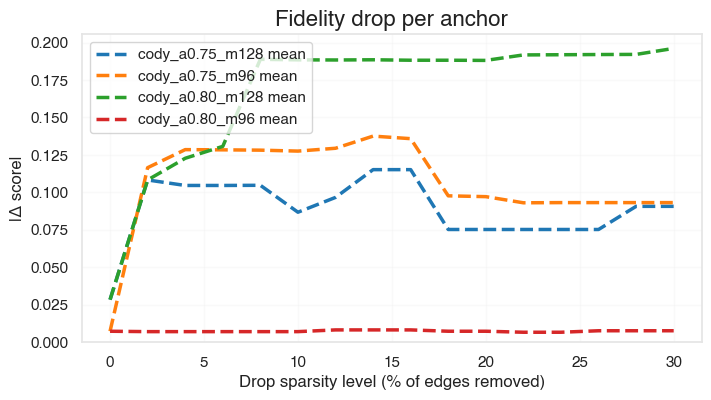

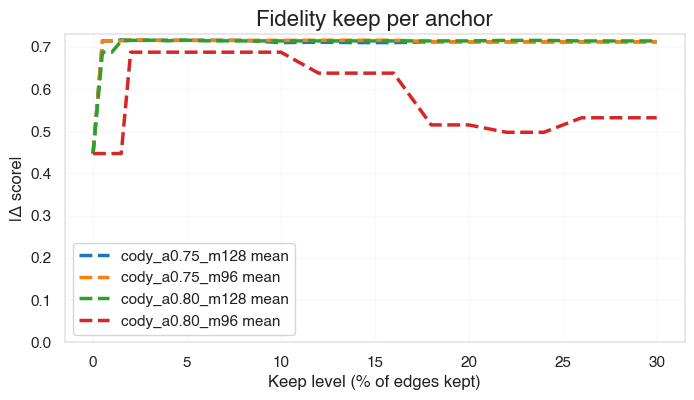

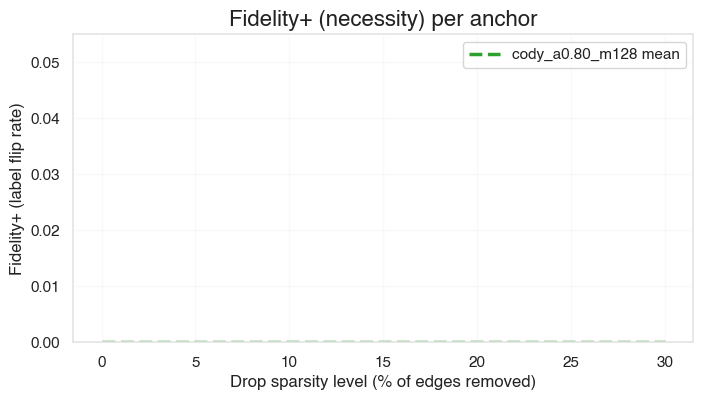

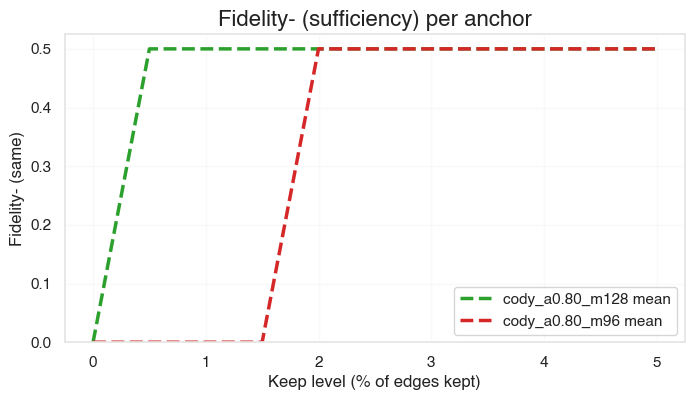

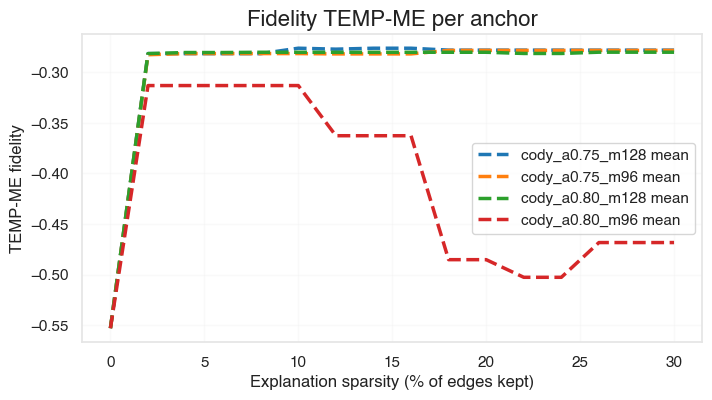

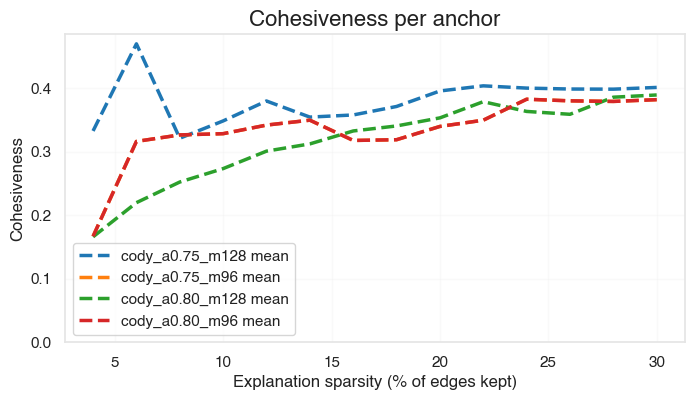

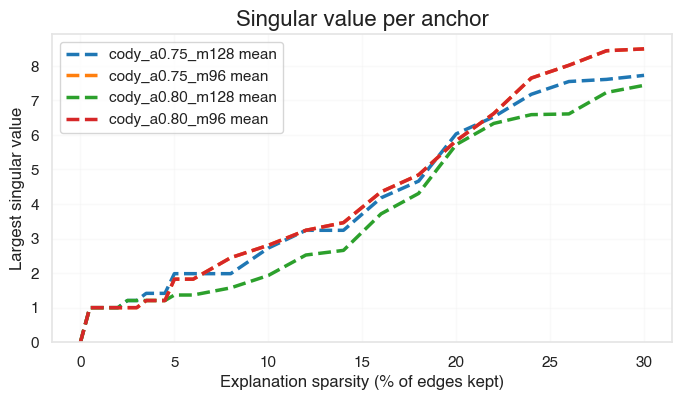


Fidelity drop (prefix=fidelity_drop.@):
  cody_a0.75_m128: mean=0.0889, min=0.0046, max=0.2258, n=32
  cody_a0.75_m96: mean=0.1062, min=0.0028, max=0.2723, n=32
  cody_a0.80_m128: mean=0.1670, min=0.0046, max=0.3876, n=32
  cody_a0.80_m96: mean=0.0074, min=0.0028, max=0.0137, n=32

Fidelity keep (prefix=fidelity_keep.@):
  cody_a0.75_m128: mean=0.7019, min=0.4336, max=0.9986, n=48
  cody_a0.75_m96: mean=0.7028, min=0.4336, max=0.9986, n=48
  cody_a0.80_m128: mean=0.7008, min=0.4336, max=0.9972, n=48
  cody_a0.80_m96: mean=0.5912, min=0.4336, max=0.9403, n=48

Fidelity+ (necessity) (prefix=fidelity_plus.@):
  cody_a0.80_m128: mean=0.0000, min=0.0000, max=0.0000, n=48

Fidelity- (sufficiency) (prefix=fidelity_minus.@):
  cody_a0.80_m128: mean=0.4545, min=0.0000, max=1.0000, n=22
  cody_a0.80_m96: mean=0.3182, min=0.0000, max=1.0000, n=22

TEMP-ME fidelity (prefix=fidelity_tempme.@):
  cody_a0.75_m128: mean=-0.2957, min=-0.5664, max=0.0143, n=32
  cody_a0.75_m96: mean=-0.2972, min=-0.566

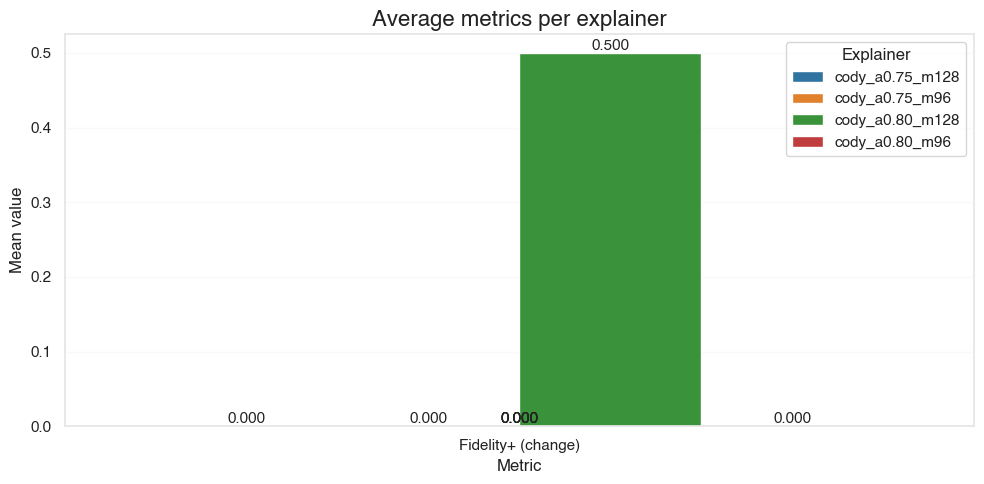

Fidelity+ (necessity) aggregate per explainer:


,Fidelity+ (change)
explainer,
cody_a0.75_m128,0.0
cody_a0.75_m96,0.0
cody_a0.80_m128,0.5
cody_a0.80_m96,0.0


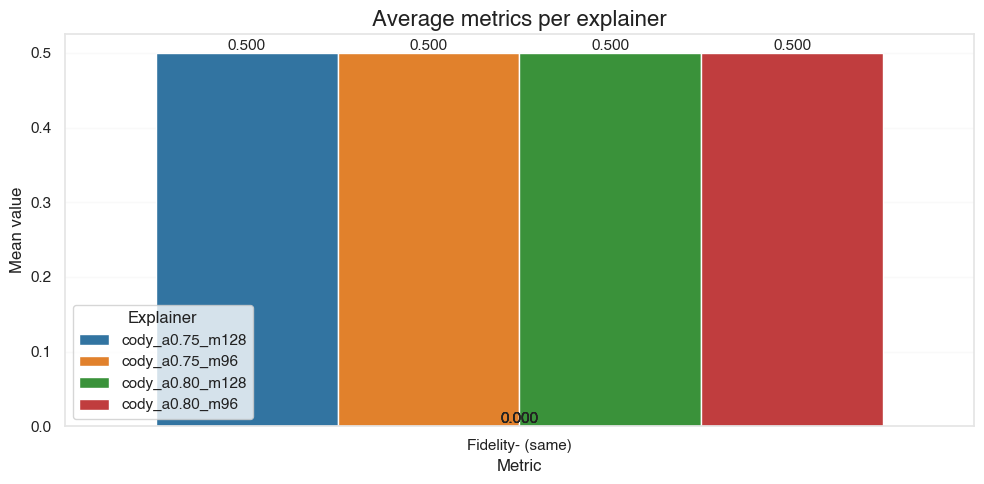

Fidelity- (sufficiency) aggregate per explainer:


,Fidelity- (same)
explainer,
cody_a0.75_m128,0.5
cody_a0.75_m96,0.5
cody_a0.80_m128,0.5
cody_a0.80_m96,0.5


In [27]:
from pathlib import Path
import pandas as pd

metrics_frames = []
metrics_paths = sorted(Path(cfg.out_dir).glob("*/metrics.csv"))
for metrics_path in metrics_paths:
    try:
        df = pd.read_csv(metrics_path)
    except pd.errors.EmptyDataError:
        continue
    if not df.empty:
        metrics_frames.append(df)

if not metrics_frames:
    for explainer in EXPLAINERS:
        metrics_path = Path(cfg.out_dir) / explainer.alias / "metrics.csv"
        if metrics_path.exists():
            try:
                df = pd.read_csv(metrics_path)
            except pd.errors.EmptyDataError:
                continue
            if not df.empty:
                metrics_frames.append(df)

if not metrics_frames:
    raise FileNotFoundError(f"No non-empty metrics.csv found under {cfg.out_dir}")

metrics_df = pd.concat(metrics_frames, ignore_index=True)
print(f"Loaded metrics for {len(metrics_frames)} explainers")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

# If explainer labels are identical but run_id differs, use run_id for plotting.
if "run_id" in metrics_df.columns:
    explainer_unique = metrics_df["explainer"].nunique() if "explainer" in metrics_df.columns else 0
    run_unique = metrics_df["run_id"].nunique()
    if explainer_unique <= 1 and run_unique > 1:
        metrics_df = metrics_df.copy()
        metrics_df["explainer"] = metrics_df["run_id"]

# Include all hyperparameter variants by default (treat as distinct explainers)
VIS_EXPLAINERS = sorted(metrics_df["explainer"].unique())
# Set to a list to filter, e.g. ["cody_a0.75_m96"]
if VIS_EXPLAINERS:
    metrics_df = filter_explainers(metrics_df, include=VIS_EXPLAINERS)

explainer_order = VIS_EXPLAINERS or sorted(metrics_df["explainer"].unique())
metrics_df, palette = prepare_metrics_plotting(
    metrics_df, explainer_order=explainer_order
)

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]


METRICS_TO_PLOT = [
    "fidelity_minus.value",
    "fidelity_plus.value",
    "sparsity.ratio",
    "aufsc.value",
    "elapsed_sec",
]

_ = plot_selected_metrics(
    metrics_df,
    METRICS_TO_PLOT,
    palette=palette,
    group_col="explainer",
)


In [16]:
import re

def _parse_cody_alias(alias: str):
    m = re.match(r"cody_a(?P<alpha>\d+(?:\.\d+)?)_m(?P<mmax>\d+)", str(alias))
    if not m:
        return {"alias": alias}
    return {
        "alias": alias,
        "alpha": float(m.group("alpha")),
        "mmax": int(m.group("mmax")),
    }

def _pick_best(series, minimize: bool = False):
    series = series.dropna()
    if series.empty:
        return None, None
    if minimize:
        return series.idxmin(), float(series.min())
    return series.idxmax(), float(series.max())

LOWER_IS_BETTER = {"elapsed_sec"}

best_rows = []
exclude_cols = {"run_id", "anchor_idx", "context_fp"}

# Scalar metrics (non-curve)
for col in metrics_df.columns:
    if col in exclude_cols or '@' in col:
        continue
    if not pd.api.types.is_numeric_dtype(metrics_df[col]):
        continue
    minimize = col in LOWER_IS_BETTER
    series = metrics_df.groupby("explainer")[col].mean()
    best_alias, best_val = _pick_best(series, minimize=minimize)
    if best_alias is None:
        continue
    row = {"metric": col, "direction": "min" if minimize else "max", "value": best_val}
    row.update(_parse_cody_alias(best_alias))
    best_rows.append(row)

# Curve metrics (aggregate mean across curve columns)
curve_prefixes = sorted({c.split('@', 1)[0] + '@' for c in metrics_df.columns if '@' in c})
for prefix in curve_prefixes:
    cols = [c for c in metrics_df.columns if c.startswith(prefix)]
    if not cols:
        continue
    series = metrics_df.groupby("explainer")[cols].mean().mean(axis=1)
    best_alias, best_val = _pick_best(series, minimize=False)
    if best_alias is None:
        continue
    row = {"metric": f"{prefix}mean", "direction": "max", "value": best_val}
    row.update(_parse_cody_alias(best_alias))
    best_rows.append(row)

best_params_df = pd.DataFrame(best_rows)
best_params_df = best_params_df.sort_values(["metric"]).reset_index(drop=True)
print("Best hyperparameters per metric (mean over anchors):")
display(best_params_df)


Best hyperparameters per metric (mean over anchors):


,metric,direction,value,alias,alpha,mmax
0,acc_auc.acc@mean,max,0.697246,cody_a0.80_m128,0.80,128
1,acc_auc.auc,max,0.705045,cody_a0.80_m128,0.80,128
2,cohesiveness.@mean,max,0.380829,cody_a0.75_m128,0.75,128
3,elapsed_sec,min,117.705231,cody_a0.75_m128,0.75,128
4,fidelity_drop.@mean,max,0.167031,cody_a0.80_m128,0.80,128
5,fidelity_drop.prediction_drop.@mean,max,0.995626,cody_a0.80_m96,0.80,96
6,fidelity_drop.prediction_full,max,0.988247,cody_a0.75_m128,0.75,128
7,fidelity_keep.@mean,max,0.702846,cody_a0.75_m96,0.75,96
8,fidelity_keep.prediction_full,max,0.988247,cody_a0.75_m128,0.75,128
9,fidelity_keep.prediction_keep.@mean,max,0.697396,cody_a0.75_m128,0.75,128


In [17]:
# Singular value summary (mean/max across sparsity levels)
sv_cols = [c for c in ("singular_value.mean", "singular_value.max") if c in metrics_df.columns]
if sv_cols and 'explainer' in metrics_df.columns:
    sv_summary = metrics_df.groupby('explainer', dropna=False)[sv_cols].mean().reset_index()
    display(sv_summary.sort_values(by=sv_cols[0], ascending=False))
else:
    print('Singular value metric not found in metrics.csv — rerun with the metric enabled.')


,explainer,singular_value.mean,singular_value.max
1,cody_a0.75_m96,3.311284,8.492354
3,cody_a0.80_m96,3.311284,8.492354
0,cody_a0.75_m128,3.219639,7.725358
2,cody_a0.80_m128,2.891518,7.436794


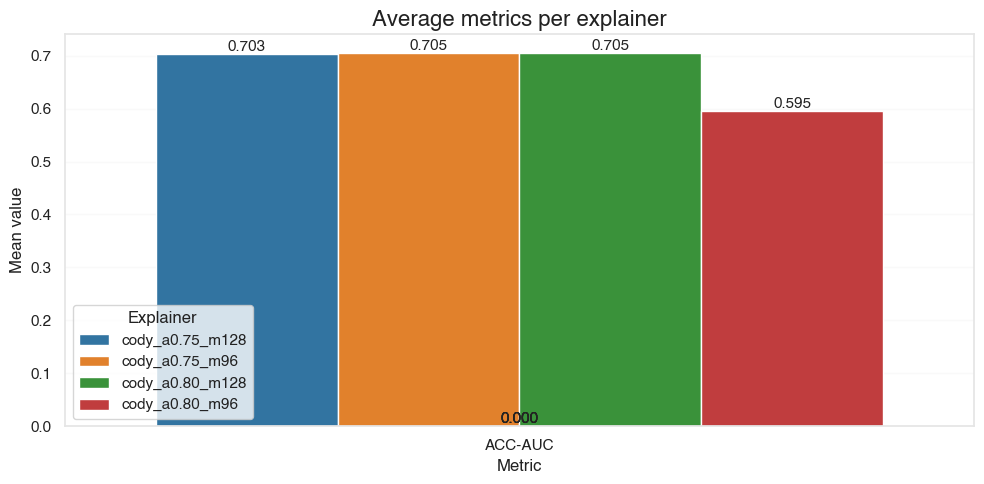

ACC-AUC aggregate (per explainer):


,ACC-AUC
explainer,
cody_a0.75_m128,0.703221
cody_a0.75_m96,0.704815
cody_a0.80_m128,0.705045
cody_a0.80_m96,0.594867


In [18]:
if 'acc_auc.auc' in metrics_df.columns and 'explainer' in metrics_df.columns:
    acc_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('ACC-AUC', 'acc_auc.auc')],
        agg='mean',
        palette=palette,
    )
    print('ACC-AUC aggregate (per explainer):')
    display(acc_summary)
else:
    print('ACC-AUC metric not found in metrics.csv — rerun with the metric enabled.')


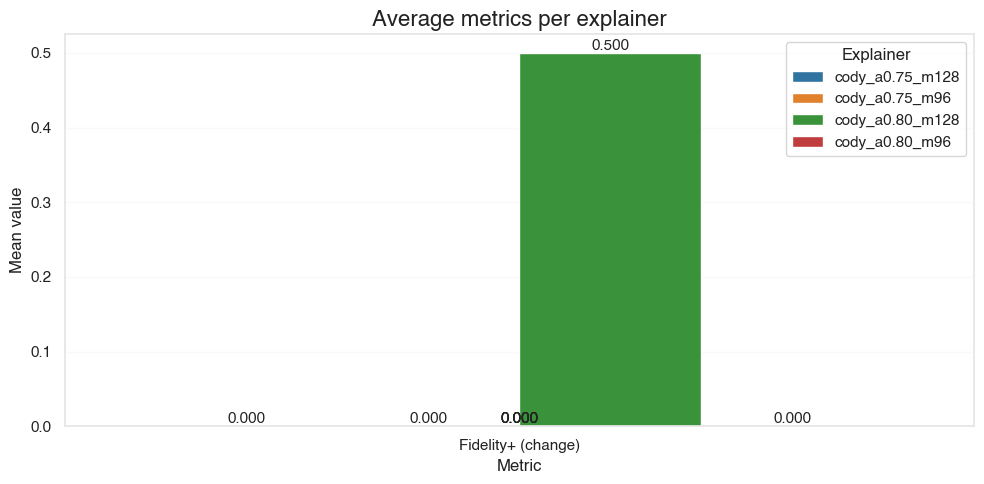

Fidelity+ (necessity) aggregate per explainer:


,Fidelity+ (change)
explainer,
cody_a0.75_m128,0.0
cody_a0.75_m96,0.0
cody_a0.80_m128,0.5
cody_a0.80_m96,0.0


In [19]:
# Fidelity+ (necessity)
if 'fidelity_plus.change' in metrics_df.columns and 'explainer' in metrics_df.columns:
    fp_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('Fidelity+ (change)', 'fidelity_plus.change')],
        agg='mean',
        palette=palette,
    )
    print('Fidelity+ (necessity) aggregate per explainer:')
    display(fp_summary)
else:
    print('Fidelity+ metric not found in metrics.csv — rerun with the metric enabled.')


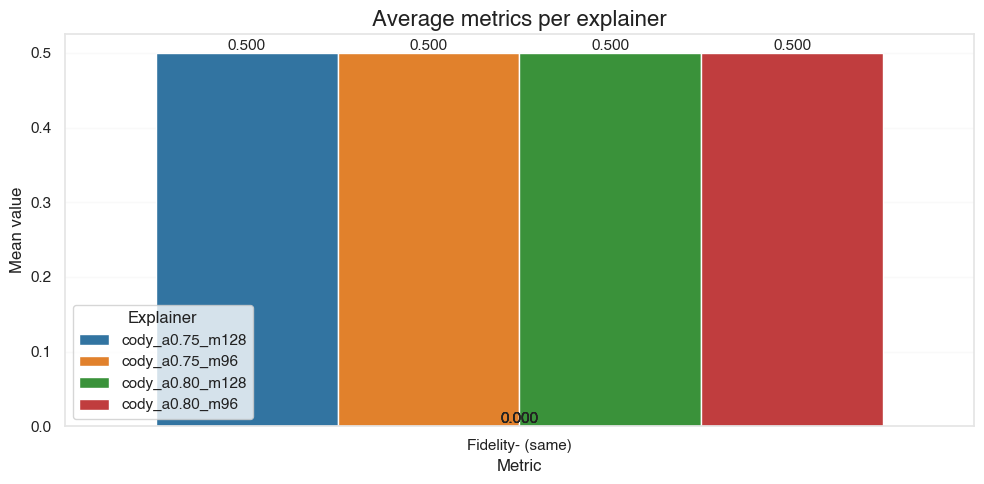

Fidelity- (sufficiency) aggregate per explainer:


,Fidelity- (same)
explainer,
cody_a0.75_m128,0.5
cody_a0.75_m96,0.5
cody_a0.80_m128,0.5
cody_a0.80_m96,0.5


In [20]:
# Fidelity- (sufficiency)
if 'fidelity_minus.same' in metrics_df.columns and 'explainer' in metrics_df.columns:
    fm_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('Fidelity- (same)', 'fidelity_minus.same')],
        agg='mean',
        palette=palette,
    )
    print('Fidelity- (sufficiency) aggregate per explainer:')
    display(fm_summary)
else:
    print('Fidelity- metric not found in metrics.csv — rerun with the metric enabled.')


# Runtime per explainer

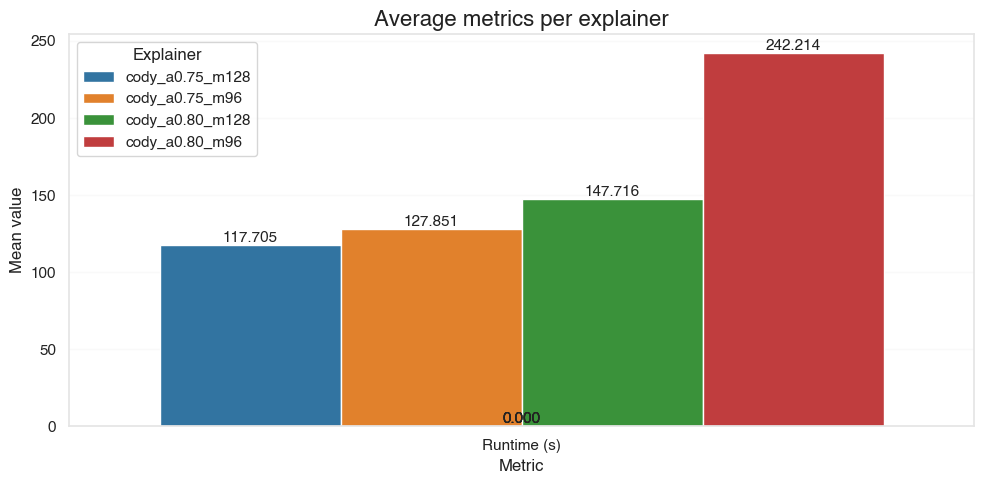

Runtime (seconds) aggregate per explainer:


,Runtime (s)
explainer,
cody_a0.75_m128,117.705231
cody_a0.75_m96,127.851102
cody_a0.80_m128,147.716071
cody_a0.80_m96,242.214134


In [21]:
# Runtime (seconds)
if 'elapsed_sec' in metrics_df.columns and 'explainer' in metrics_df.columns:
    runtime_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('Runtime (s)', 'elapsed_sec')],
        agg='mean',
        palette=palette,
    )
    print('Runtime (seconds) aggregate per explainer:')
    display(runtime_summary)
else:
    print('Runtime column not found in metrics.csv — rerun with timings enabled.')


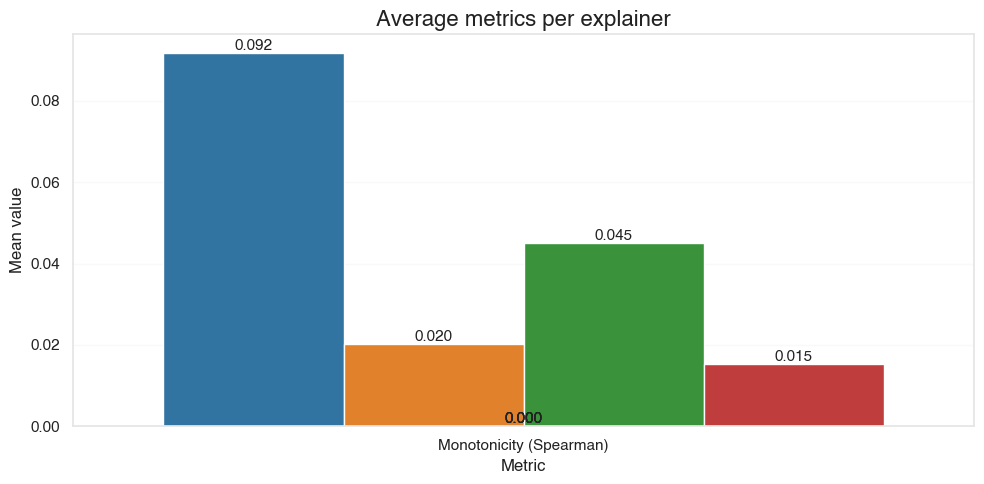

Monotonicity (Spearman rho) aggregate per explainer:


,Monotonicity (Spearman)
explainer,
cody_a0.75_m128,0.091788
cody_a0.75_m96,0.020142
cody_a0.80_m128,0.045155
cody_a0.80_m96,0.015278


In [22]:
# Monotonicity (Spearman rho)
if 'monotonicity.spearman_rho' in metrics_df.columns:
    mono_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('Monotonicity (Spearman)', 'monotonicity.spearman_rho')],
        agg='mean',
        palette=palette,
    )
    print('Monotonicity (Spearman rho) aggregate per explainer:')
    display(mono_summary)
else:
    print('Monotonicity metric not found in metrics.csv — rerun with the metric enabled.')


### Prediction stability vs. sparsity

Percentage of anchors whose masked subgraph keeps the same prediction as the full subgraph, sampled every 0.02 sparsity points (0.00–0.30). The normalized area totals 100% when predictions stay identical across the entire range.


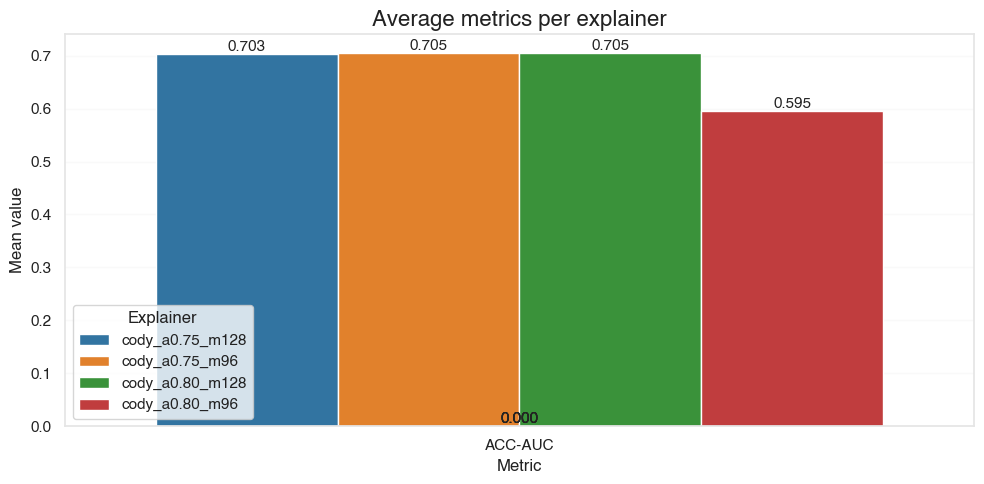

ACC-AUC aggregate (per explainer):


,ACC-AUC
explainer,
cody_a0.75_m128,0.703221
cody_a0.75_m96,0.704815
cody_a0.80_m128,0.705045
cody_a0.80_m96,0.594867


In [23]:
if 'acc_auc.auc' in metrics_df.columns and 'explainer' in metrics_df.columns:
    acc_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('ACC-AUC', 'acc_auc.auc')],
        agg='mean',
        palette=palette,
    )
    print('ACC-AUC aggregate (per explainer):')
    display(acc_summary)
else:
    print('ACC-AUC metric not found in metrics.csv — rerun with the metric enabled.')


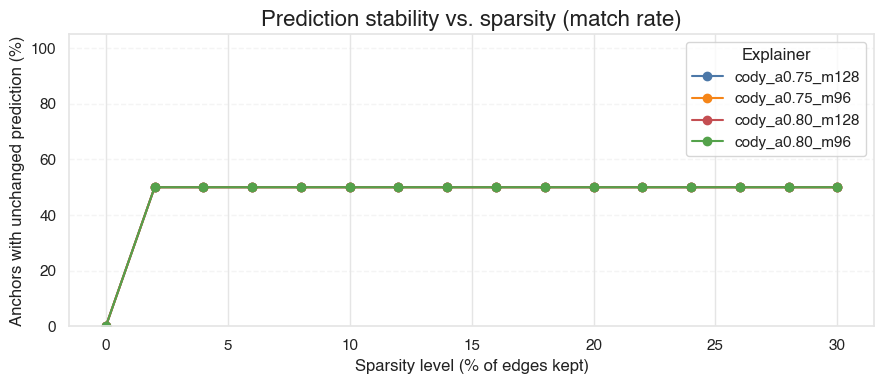

Match rate table (% of anchors with unchanged prediction):


,0%,2%,4%,6%,8%,10%,12%,14%,16%,18%,20%,22%,24%,26%,28%,30%
explainer,,,,,,,,,,,,,,,,
cody_a0.75_m128,0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
cody_a0.75_m96,0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
cody_a0.80_m128,0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
cody_a0.80_m96,0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0



Normalized area under stability curve (100% = perfect stability across the range)


,auc_raw,auc_normalized_percent
explainer,,
cody_a0.75_m128,0.145,48.333333
cody_a0.75_m96,0.145,48.333333
cody_a0.80_m128,0.145,48.333333
cody_a0.80_m96,0.145,48.333333


In [24]:
_ = plot_prediction_match_rate(metrics_df, group_col="explainer")


In [25]:
if metrics_df.empty:
    raise RuntimeError("metrics_df is empty; nothing to evaluate.")

fidelity_cols = [c for c in metrics_df.columns if c.startswith("fidelity_")]
sparsity_cols = [c for c in metrics_df.columns if "sparsity" in c]

summary = {}

# Fidelity checks
fid_arrays = []
for col in fidelity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite = vals[np.isfinite(vals)]
    if finite.size == 0:
        raise RuntimeError(f"{col} has no finite values (all NaN/inf).")
    fid_arrays.append(finite)
    frac_nan = 1.0 - (finite.size / max(1, vals.size))
    if frac_nan > 0:
        print(f"⚠️  {col}: {frac_nan:.1%} of values were NaN and were dropped from sanity checks.")

if fid_arrays:
    all_fid = np.concatenate(fid_arrays)
    summary["fidelity"] = {
        "mean": float(all_fid.mean()),
        "std": float(all_fid.std()),
        "min": float(all_fid.min()),
        "max": float(all_fid.max()),
    }
else:
    print("No fidelity_* columns present; skipping fidelity sanity checks.")

# Sparsity checks (should live in [0, 1])
ratio_suffixes = (".zero_frac", ".density")
count_suffixes = (".n", ".l0")

for col in sparsity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite_mask = np.isfinite(vals)
    finite = vals[finite_mask]
    if finite.size == 0:
        print(f"⚠️  {col}: all values are NaN/inf; skipping.")
        continue
    suffix = next((s for s in ratio_suffixes + count_suffixes if col.endswith(s)), None)
    if suffix in count_suffixes:
        if (finite < -1e-6).any():
            raise RuntimeError(f"{col} contains negative counts: min={finite.min():.3f}")
        summary.setdefault("sparsity_counts", {})[col] = float(finite.mean())
        continue
    if suffix in ratio_suffixes:
        if (finite < -1e-6).any() or (finite > 1 + 1e-6).any():
            raise RuntimeError(
                f"{col} contains values outside [0, 1]: min={finite.min():.3f}, max={finite.max():.3f}"
            )
        summary.setdefault("sparsity", {})[col] = float(finite.mean())
        continue
    summary.setdefault("sparsity_misc", {})[col] = float(finite.mean())
    missing_frac = 1.0 - (finite.size / max(1, vals.size))
    if missing_frac > 0:
        print(f"⚠️  {col}: skipped {missing_frac:.1%} missing values.")

# Monotonicity checks for fidelity series (per row)
trend_expectations = {
    "fidelity_drop": ("non_decreasing", "Removing more edges should not reduce the drop in score."),
    "fidelity_keep": ("non_decreasing", "Keeping more edges should not reduce coverage (expect absolute change grows)."),
}
pattern = re.compile(r"^(fidelity_(?:drop|keep))\.@(.*)")
violations = []

for prefix, (expect, desc) in trend_expectations.items():
    prefix_cols = [c for c in fidelity_cols if c.startswith(prefix + ".@")]
    if not prefix_cols:
        continue
    # sort columns by sparsity level
    col_info = []
    for col in prefix_cols:
        m = pattern.match(col)
        if not m:
            continue
        level = m.group(2)
        try:
            level_val = float(level.split('=')[1]) if level.startswith('s=') else float(level)
        except ValueError:
            continue
        col_info.append((level_val, col))
    col_info.sort()
    if not col_info:
        continue

    for row_idx in metrics_df.index:
        values = []
        for lvl, col in col_info:
            val = metrics_df.at[row_idx, col]
            if val is None:
                continue
            try:
                val_f = float(val)
            except (TypeError, ValueError):
                continue
            if not np.isfinite(val_f):
                continue
            values.append((lvl, val_f))
        if len(values) < 2:
            continue
        values.sort()
        seq = np.array([v for _, v in values], dtype=float)
        diffs = np.diff(seq)
        tol = 1e-6
        if expect == "non_decreasing" and np.any(diffs < -tol):
            violations.append((prefix, row_idx, [lvl for lvl, _ in values], seq.tolist(), desc))

if violations:
    lines = ["Fidelity monotonicity check failed for the following rows:"]
    for prefix, row_idx, lvls, seq, desc in violations[:5]:
        anchor = metrics_df.at[row_idx, "anchor_idx"] if "anchor_idx" in metrics_df.columns else row_idx
        expl = metrics_df.at[row_idx, "explainer"] if "explainer" in metrics_df.columns else "?"
        lines.append(
            f"  [{prefix}] row={row_idx} (anchor={anchor}, explainer={expl}): levels={lvls} values={seq} :: {desc}"
        )
    print("\n".join(lines))


⚠️  fidelity_plus.@s=0: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.005: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.01: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.015: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.02: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.025: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.03: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.035: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.04: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.045: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@s=0.05: 75.0% of values were NaN and were dropped from sanity checks.
⚠️  fidelity_plus.@

In [26]:
print("Metric sanity summary:")
for key, val in summary.items():
    print(f"  {key}: {val}")

Metric sanity summary:
  fidelity: {'mean': 0.439000187302014, 'std': 0.48099056336644075, 'min': -0.566447219874642, 'max': 1.0}
  sparsity_counts: {'sparsity.edges.n': 112.0, 'sparsity.edges.l0': 96.875, 'sparsity.nodes.n': 0.0, 'sparsity.nodes.l0': 0.0}
  sparsity: {'sparsity.edges.zero_frac': 0.8776041666666667, 'sparsity.edges.density': 0.12239583333333331}
  sparsity_misc: {'sparsity.edges.gini': 0.9319618487932484, 'sparsity.edges.entropy': 1.0006233072946, 'sparsity.edges.mean': 0.04591271722650461, 'sparsity.edges.std': 0.4505104145801619}
